In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import nltk
from sklearn.metrics import f1_score
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from imblearn.over_sampling import BorderlineSMOTE
from sklearn import svm

from scipy import stats
from sklearn.model_selection import GridSearchCV
import seaborn as sns
from sklearn.pipeline import Pipeline

%matplotlib inline

# preprocessing

In [25]:
combined = pd.read_csv('./wordBag.csv', sep = '\t')

drop the duplicates based on lyrics

In [26]:
combined.shape

(419887, 4)

In [27]:
len(combined.lyrics.unique())

302368

In [28]:
data = combined.drop_duplicates(['lyrics'])

In [29]:
data.shape

(302368, 4)

In [30]:
data[:5]

,song,lyrics,artist,wordBag
0,ego-remix,"Oh baby, how you doing?\nYou know I'm gonna cu...",beyonce-knowles,oh baby you know i gon na cut right chase some...
1,then-tell-me,"playin' everything so easy,\nit's like you see...",beyonce-knowles,playin everything easy like seem sure still wa...
2,honesty,If you search\nFor tenderness\nIt isn't hard t...,beyonce-knowles,if search for tenderness it hard find you love...
3,you-are-my-rock,"Oh oh oh I, oh oh oh I\n[Verse 1:]\nIf I wrote...",beyonce-knowles,oh oh oh i oh oh oh i verse if i wrote book st...
4,black-culture,"Party the people, the people the party it's po...",beyonce-knowles,party people people party popping sitting arou...


Try subtract artists with less than five songs, as it is too hard for us to identify the artists with such few samples

In [31]:
# filter artists with less than a certain number of songs in the data set
def filtering(df, n):
    count = df.artist.value_counts()
    artist = pd.DataFrame({'artist': count.index, 'counts': count.values})
    less_artist = artist[artist['counts']< n]
    key_diff = set(df.artist).difference(less_artist.artist)
    where_diffkey = df.artist.isin(key_diff)
    data_s = df[where_diffkey]
    return data_s

In [32]:
data_s = filtering(data, 100)

In [33]:
data_s.shape

(116107, 4)

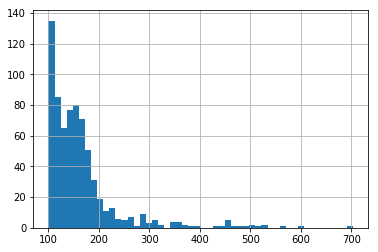

In [34]:
data_s.artist.value_counts().hist(bins = 50)

In [35]:
data_s.artist.value_counts().describe()

count    706.000000
mean     164.457507
std       75.306892
min      100.000000
25%      118.000000
50%      147.000000
75%      175.000000
max      703.000000
Name: artist, dtype: float64

# baseline model

In [36]:
# sample % data to check the baseline model
data_sample = pd.DataFrame.sample(data_s, 20000, random_state = 124)

In [37]:
# split the data into training and test dataset
train, test = train_test_split(data_s, test_size=0.2, random_state = 124)

Filter both train and test to make sure that they have same amount of artists

In [38]:
train_s = filtering(train, 50)

In [39]:
train_m = train_s[train_s['artist'].isin(test.artist)]
test_m = test[test.artist.isin(train_s.artist)]

In [40]:
train_m.artist.value_counts().describe()

count    706.000000
mean     131.565156
std       60.251312
min       72.000000
25%       94.000000
50%      117.000000
75%      140.750000
max      549.000000
Name: artist, dtype: float64

In [41]:
test_m.shape

(23222, 4)

We finally get 2644 artists to be identified. 40085 instances for training set and 11673 instances for test set

In [42]:
# use tf-idf to form the matrix
vectorizer_t = TfidfVectorizer(max_features = 1000)
X_t = vectorizer_t.fit_transform(corpus)

In [45]:
corpus = train_m['wordBag'].values.astype(str).tolist()
y = train_m['artist']

try over sampling the minory class

In [46]:
X_resampled, y_resampled = BorderlineSMOTE(k_neighbors=5).fit_resample(X_t,y)

ValueError: Found input variables with inconsistent numbers of samples: [4334, 92885]

In [ ]:
# count the words and form a matrix X as the input features
vectorizer = CountVectorizer(max_features=5000)
X = vectorizer.fit_transform(corpus)

In [ ]:
# add SVD to our model
svd = TruncatedSVD(n_components=200)
X_d = svd.fit_transform(X)

In [ ]:
# use SVM as our classifier
clf = LinearSVC()
clf.fit(X_d,y)

In [ ]:
# predict the f1 score on the test set with the SVM model
corpus_test = test_m['wordBag'].values.astype(str).tolist()
X_test = vectorizer.fit_transform(corpus_test)
X_test_d = svd.fit_transform(X_test)
y_pred = clf.predict(X_test_d)
y_true = test_m['artist']
f1_score(y_true, y_pred, average = 'macro')  

## popularity model

In [9]:
class popularityModel(object):
    """
    basically is returning the Mode
    """
    def __init__(self):
        self.mode = None
        return 
    
    def fit(self, X, y):
        """
        X: (number of examples k, number of features d.) nd array.
        y: (number of examples, ) nd array, or panda.series.
        """
        if X.shape[0] != y.shape[0]:
            print("error, dim not match")
            return
        self.mode = stats.mode(y.values, nan_policy='omit')[0][0]
        
    def predict(self, X):
        """
        X: (number of examples k_1, number of features d.) nd array.
        """
        if self.mode == None:
            print("Please fit the model first.")
            return
        
        return np.array([self.mode] * X.shape[0])
        
    

In [21]:
%time
corpus_test = test_m['wordBag'].values.astype(str).tolist()

X_test = vectorizer.fit_transform(corpus_test)
X_test_d = svd.fit_transform(X_test)

popuralityMod = popularityModel()
y_true = test_m['artist']

popuralityMod.fit(X_d, y)

y_pred = popuralityMod.predict(X_test_d)
f1_score(y_true, y_pred, average = 'macro') 

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.91 µs


/Users/mbp/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:248: RuntimeWarning: The input array could not be properly checked for nan values. nan values will be ignored.
  "values. nan values will be ignored.", RuntimeWarning)
/Users/mbp/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


1.8662757667242546e-05

## try less artists

In [7]:
artist_100 = data.artist.value_counts()[:100]

In [8]:
data_100 = data[data.artist.isin(artist_100.index)]

In [9]:
# split the data into training and test dataset
train, test = train_test_split(data_100, test_size=0.2, random_state = 124, stratify = data_100.artist)

In [12]:
corpus = train['wordBag'].values.astype(str).tolist()

In [49]:

X = vectorizer.fit_transform(corpus)
X_d = svd.fit_transform(X)
y = train.artist
popuralityMod.fit(X_d, y)

/Users/mbp/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:248: RuntimeWarning: The input array could not be properly checked for nan values. nan values will be ignored.
  "values. nan values will be ignored.", RuntimeWarning)


In [54]:
corpus_test = test['wordBag'].values.astype(str).tolist()

X_test = vectorizer.fit_transform(corpus_test)
X_test_d = svd.fit_transform(X_test)
y_pred = popuralityMod.predict(X_test_d)
y_true = test['artist']

f1_score(y_true, y_pred, average = 'macro') 

/Users/mbp/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


0.00044705136334812943

With top 100 artists, our popularity model have f1 score = 0.000447

### try top 10 artists

In [13]:
artist_10 = data.artist.value_counts()[:10]
data_10 = data[data.artist.isin(artist_10.index)]

In [14]:
# split the data into training and test dataset
train, test = train_test_split(data_10, test_size=0.2, random_state = 124, stratify = data_10.artist)
corpus = train['wordBag'].values.astype(str).tolist()

In [10]:
vectorizer = CountVectorizer(max_features=5000)
svd = TruncatedSVD(n_components=200)
popuralityMod = popularityModel()

X = vectorizer.fit_transform(corpus)
X_d = svd.fit_transform(X)
y = train.artist
popuralityMod.fit(X_d, y)

/Users/mbp/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:248: RuntimeWarning: The input array could not be properly checked for nan values. nan values will be ignored.
  "values. nan values will be ignored.", RuntimeWarning)


In [11]:
corpus_test = test['wordBag'].values.astype(str).tolist()

X_test = vectorizer.fit_transform(corpus_test)
X_test_d = svd.fit_transform(X_test)
y_pred = popuralityMod.predict(X_test_d)
y_true = test['artist']

f1_score(y_true, y_pred, average = 'macro') 

/Users/mbp/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


0.023020408163265303

## top 100 artists with SVM model

In [15]:
clf = LinearSVC()

In [55]:

clf.fit(X_d, y)
y_pred = clf.predict(X_test_d)
y_true = test['artist']

f1_score(y_true, y_pred, average = 'macro') 

/Users/mbp/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/mbp/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


0.01163759813199625

### try top 10 artists

In [16]:
clf.fit(X_d, y)
y_pred = clf.predict(X_test_d)
y_true = test['artist']

f1_score(y_true, y_pred, average = 'macro') 

NameError: name 'X_d' is not defined

In [101]:
vectorizer_t = TfidfVectorizer(max_features = 350, ngram_range = (1,1))
X_t = vectorizer_t.fit_transform(corpus)
X_test_t = vectorizer_t.fit_transform(corpus_test)
clf.fit(X_t, y)
y_pred = clf.predict(X_test_t)


f1_score(y_true, y_pred, average = 'macro') 

0.21444512051309256

In [91]:
# svm with svd
svd = TruncatedSVD(n_components=300)
X_t_d = svd.fit_transform(X_t)
X_test_t_d = svd.fit_transform(X_test_t)
clf.fit(X_t_d, y)
y_pred = clf.predict(X_test_t_d)
f1_score(y_true, y_pred, average = 'macro') 

0.18321698982562867

SVD is not effective

## feature egineering

### n-grams with SVM

grid search to find the optimal parameters for n-grams maximum features, ngram_range and # of components in SVD.

We conduct the grid search with maximum feaures 300,500,700,900,1200,1500,2000 and ngram_range (1,1),(1,2),(1,3),(1,4),(1,5)

In [44]:
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('model', LinearSVC())
])
parameters = {'tfidf__max_features':[300,500,700,900,1200,1500,2000,3000], 'tfidf__ngram_range':[(1,1),(1,2),(1,3),(1,4),(1,5)]}

clf_grid = GridSearchCV(pipeline, parameters, cv=5, n_jobs=-1, verbose=True)
clf_grid.fit(corpus,y)

Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  7.6min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:  8.2min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('tfidf', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,...ax_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0))]),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'tfidf__max_features': [300, 500, 700, 900, 1200, 1500, 2000, 3000], 'tfidf__ngram_range': [(1, 1), (1, 2), (1, 3), (1, 4), (1, 5)]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=True)

In [51]:
results = pd.melt(
pd.DataFrame(clf_grid.cv_results_),
id_vars=['param_tfidf__max_features', 'param_tfidf__ngram_range'],
value_vars=[
'mean_test_score'
],
value_name='f1_scores'
)

results = results.drop(['variable'], axis=1)

/Users/mbp/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/mbp/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/mbp/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split2_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/mbp/anaconda3/lib/python3.7/si

In [150]:
def plot_results(results, title,xlable,ylable, huelable):
    f, ax = plt.subplots(figsize=(8, 5))
    sns.lineplot(ax=ax,
    x= xlable,
    y= ylable,
    hue = huelable,
    data=results)
    ax.set_xlabel(xlable)
    ax.set_ylabel('mean of prediction accuracy')
    ax.set_title(title)
    ax.legend(loc='lower right')


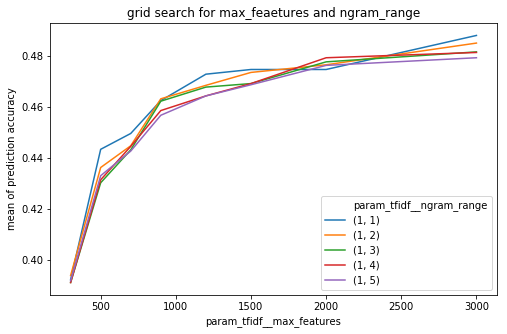

In [54]:

plot_results(results,'grid search for max_feaetures and ngram_range', 'param_tfidf__max_features','f1_scores','param_tfidf__ngram_range')

From the grid search, we find that the performance of models with unigram and bigram reach a plateau after the number fo maximum features exceed 1500 and then increasing again. While, ngram range larger than (1,2) seems to keep reach the plateau after number of maximum features exceeds 2000.

In [47]:
clf_grid.best_params_

{'tfidf__max_features': 3000, 'tfidf__ngram_range': (1, 1)}

### other features

In [ ]:
class uniqueWordRatioVec(object):
    '''
    convet bag of words to 
    [number of unique words/length of the lyrics] vec
    '''
    
    def __init__():
        '''
        self.dim: number of length of X, which is number lyrics.
        '''
        self.dim = 0
        self.word = []
        self.lengths = []
        return None
    
    def fitTransForm(X):
        """
        length self.dim, but contains [k_0, k_1, .. ,k_n] for k_i in range(0, 1)
        """
        for wordbag in X:
            
            

In [48]:
corpus

['snoop doggy dogg dre door ready make entrance back cause know rip shit give microphone first i bust like bubble compton long beach together know trouble ai nothing g thang baby two niggas crazy death row label pays unfadeable please try fade but um back lecture hand perfection perfected let em understand from young g perspective and dig bitch i find contraceptive you never know could earning man and learning man time burning man now know i ai shit lieutenant ai pussy good enough get burnt i yeah realer holyfield and hookers hoes know i feel well good enough get broke proper chunk i take small piece funky stuff it like like like uh it like like like uh it like like like uh dre creep mic like phantom well i peeping i creeping i but i damn near got caught cause beeper kept beepin now time make impression felt so sit back relax strap seat belt you never ride like with producer rap control maestro at time dope rhyme i kick you know i know i flow old funky shit to add collection selection 

## other models

### other SVM

In [81]:
pipeline_c = Pipeline([
    ('tfidf', TfidfVectorizer(max_features = 3000, ngram_range = (1,1))),
    ('model', svm.SVC(gamma="scale"))
])
parameters_svc = {'model__kernel':('linear', 'rbf','poly'), 'model__C':[0.1,1, 10,20,50]}

clf_gs = GridSearchCV(pipeline_c, parameters_svc, cv=5, n_jobs=-1, verbose=True)
clf_gs.fit(corpus,y)

Fitting 5 folds for each of 15 candidates, totalling 75 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  6.2min
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed: 10.3min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('tfidf', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=3000, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,...,
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False))]),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'model__kernel': ('linear', 'rbf', 'poly'), 'model__C': [0.1, 1, 10, 20, 50]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=True)

In [82]:
results_m = pd.melt(
pd.DataFrame(clf_gs.cv_results_),
id_vars=['param_model__kernel', 'param_model__C'],
value_vars=[
'mean_test_score'
],
value_name='f1_scores'
)



/Users/mbp/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/mbp/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/mbp/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split2_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/mbp/anaconda3/lib/python3.7/si

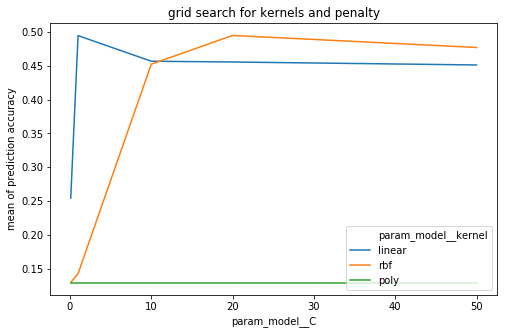

In [83]:
plot_results(results_m,'grid search for kernels and penalty', 'param_model__C','f1_scores','param_model__kernel')

In [87]:
clf_gs.best_params_

{'model__C': 20, 'model__kernel': 'rbf'}

In [88]:
results_m

,param_model__kernel,param_model__C,variable,f1_scores
0,linear,0.1,mean_test_score,0.254499
1,rbf,0.1,mean_test_score,0.129672
2,poly,0.1,mean_test_score,0.129672
3,linear,1,mean_test_score,0.494462
4,rbf,1,mean_test_score,0.142824
5,poly,1,mean_test_score,0.129672
6,linear,10,mean_test_score,0.456622
7,rbf,10,mean_test_score,0.452238
8,poly,10,mean_test_score,0.129672
9,linear,20,mean_test_score,0.455468


Linear and rbf kernel are both effective, as the penalty increasing, they two both tend to be constant. The best combination is rbf kernal and penalty equals to 20. While the score for linear SVC with small penalty is also close to the best combination. Take model complexity and training speed into consider, we could also use linear SVC with penalty equals to 1.

### random forest

In [167]:
vectorizer_t = TfidfVectorizer(max_features = 350, ngram_range = (1,1))
X_t = vectorizer_t.fit_transform(corpus)
X_test_t= vectorizer_t.fit_transform(corpus_test)

In [168]:
clf_r = RandomForestClassifier(n_estimators = 100, max_depth = 10)
clf_r.fit(X_t, y)
y_pred = clf.predict(X_test_t)

f1_score(y_true, y_pred, average = 'macro') 

0.21444512051309256

It seems that for random forest the best maximum features is not same as SVM

In [137]:
pipeline_rf = Pipeline([
    ('tfidf', TfidfVectorizer(max_features = 300, ngram_range = (1,1))),
    ('model', RandomForestClassifier())
])
parameters_rf = {'model__n_estimators':[10,100,1000], 'model__max_depth':[10,100,1000]}

clf_rf = GridSearchCV(pipeline_rf, parameters_rf, cv=5, n_jobs=-1, verbose=True)
clf_rf.fit(corpus,y)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:  4.2min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('tfidf', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=300, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
...obs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))]),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'model__n_estimators': [10, 100, 1000], 'model__max_depth': [10, 100, 1000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=True)

In [138]:
results_rf = pd.melt(
pd.DataFrame(clf_rf.cv_results_),
id_vars=['param_model__n_estimators', 'param_model__max_depth'],
value_vars=[
'mean_test_score'
],
value_name='f1_scores'
)

/Users/mbp/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/mbp/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/mbp/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split2_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/mbp/anaconda3/lib/python3.7/si

In [156]:
results_rf.param_model__max_depth = pd.to_numeric(results_rf.param_model__max_depth)

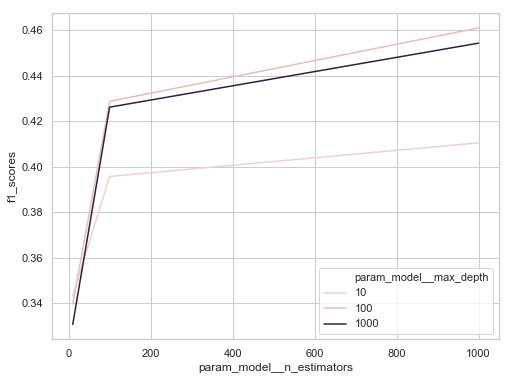

In [158]:
sns.set(style="whitegrid")

fig, ax = plt.subplots(figsize=(8, 6))

sns.lineplot(
    x='param_model__n_estimators',
    y='f1_scores',
    hue='param_model__max_depth',
    data=results_rf,
    legend="full",
    ax=ax
)

In [159]:
clf_rf.best_params_

{'model__max_depth': 100, 'model__n_estimators': 1000}

In [161]:
clf_rf.best_score_

0.4610059990770651

The best combination is 100 maximum depth with 1000 trees.

The best of all models we have tried is SVC with rbf and penalty 20, tfidf max features 3000 and unigram.